In [105]:
import os
import random
import time

from PIL import Image
from opensearchpy import OpenSearch
from sentence_transformers import SentenceTransformer
from IPython.display import display

host = 'localhost'
port = 9200
auth = ('admin', 'admin')
PATH_TO_IMAGES = "images/"
DEST_INDEX = "image-embeddings"

In [106]:
def image_embedding(image, model):
    return model.encode(image)

In [107]:
start_time = time.perf_counter()
img_model = SentenceTransformer('clip-ViT-L-14')
duration = time.perf_counter() - start_time
print(f'Duration load model = {duration}')

client = OpenSearch(
        hosts=[{'host': host, 'port': port}],
        http_compress=True,  # enables gzip compression for request bodies
        http_auth=auth,
        use_ssl=True,
        verify_certs=False
)

Duration load model = 5.7854415210022125


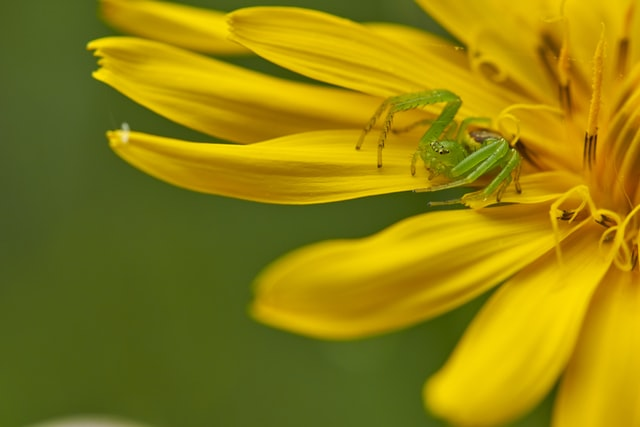

/Users/Konstantin_Perikov/projects/visual-search/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


RequestError: RequestError(400, 'search_phase_execution_exception', "failed to create query: Object's dimension=768 does not match the expected dimension=512.")

In [108]:
filenames = os.listdir(PATH_TO_IMAGES)
# random_filename = "test7.png"
random_filename = random.choice(filenames)
with Image.open(PATH_TO_IMAGES + random_filename) as image:
    # Show the image using Pillow
    display(image)
    embedding = image_embedding(image, img_model)
    # embedding = image_embedding("springs", img_model)
    query = {
        "size": 5,
        "query": {
            "script_score": {
                "query": {
                    "match_all": {}
                },
                "script": {
                    "source": "knn_score",
                    "lang": "knn",
                    "params": {
                        "field": "image_embedding",
                        "query_value": embedding.tolist(),
                        "space_type": "cosinesimil"
                    }
                }
            }
        }
    }
    # print(query)

    response = client.search(
        body=query,
        index=DEST_INDEX
    )
    print('\nSearch results:')
    hits = response["hits"]["hits"]
    for hit in hits:
        filename = hit["_source"]["image_name"]
        print()
        print(hit["_score"])
        with Image.open(PATH_TO_IMAGES + filename) as res_image:
            display(res_image)
        # Show the image using Pillow
